In [49]:
#NIA: 192901 Mario Vaz-Romero
#NIA: 193890 Arnau Colom

#Drive loader for user: Mario
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls '/content/drive/My Drive/Proyecto/data'
#myDrive = '/content/drive/My Drive/Proyecto/data'


Mounted at /content/drive
 2model.h5     4model.h5   'sin numpy.h5'   train_X.bin
 3model_2.h5   conNP.h5     test_X.bin	    train_y.bin
 3model.h5     prueba.png   test_y.bin


In [0]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.cm as cm
import skimage
from random import shuffle


#HEIGHT = 64
#WIDTH = 64
#DEPTH = 3

HEIGHT = 96
WIDTH = 96
DEPTH = 3

SIZE = HEIGHT*WIDTH*DEPTH


#DATA_PATH = '../dataset/stl10_binary/train_X.bin'
#LABEL_PATH = '../dataset/stl10_binary/train_y.bin'
DATA_PATH = '/content/drive/My Drive/Proyecto/data/train_X.bin'
LABEL_PATH = '/content/drive/My Drive/Proyecto/data/train_y.bin'

def read_labels(path_to_labels):
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f,dtype=np.uint8)
        return labels

def read_all_images(path_to_data):
    with open(path_to_data, 'rb') as f:
        all_data = np.fromfile(f,dtype=np.uint8)
        
        #Data resized to 3x64x64
        #-1 since size of the pictures depends on the input file
        images = np.reshape(all_data, (-1, 3, HEIGHT, WIDTH))
        
        #Transposing to a standard image format
        #Comment this line before training algorithms like CNNs
        images = np.transpose(images, (0,3,2,1))
        return images

def read_single_image(image_file):
    image = np.fromfile(image_file,dtype=np.uint8,count=SIZE)
    
    image  = np.reshape(image,(3,HEIGHT,WIDTH))
    
    image = np.transpose(image, (2,1,0))
    return image

def plot_image(image):
    plt.imshow(image)
    plt.show()

def display_one_image():
    with open(DATA_PATH, 'rb') as f:
        image=read_single_image(f)
        plot_image(image)

def get_shape_of_dataset():
    images= read_all_images(DATA_PATH)
    return images.shape

In [0]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [[0.299, 0.587, 0.144],[0.299, 0.587, 0.144],[0.299, 0.587, 0.144]])
  
  
images = read_all_images(DATA_PATH)
#images = rgb2gray(images)
labels = read_labels(LABEL_PATH)

In [0]:
def get_resized_images(images):
    train_X=np.empty((images.shape[0],HEIGHT,WIDTH,3),dtype=np.uint8)
    
    for i in range(images.shape[0]):
        train_X[i] = cv2.resize(images[i],(HEIGHT,WIDTH))
        
    return train_X

In [0]:
train_X = get_resized_images(images)

In [54]:
#Cambio de 5000 a -1 para que lo busque solo sin error
#images= train_X.reshape(5000,64,64,3)
#images= train_X.reshape(-1,64,64,3)
print(images.shape)

(5000, 96, 96, 3)


In [0]:
def display_images(images,n):
    size = images.shape[0]
    plt.figure(figsize=(20, 2))
    for i in range(1,n):
        ax = plt.subplot(1, n, i)
        plt.imshow(images[size - i].reshape(96, 96,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [0]:
#Shuffle the noisy image ground truth pair to randomize the noise distribution in the dataset
def pair_shuffle(images,noisy_set):
    image_pair = []
    for i in range(images.shape[0]):
        image_pair.append((images[i],noisy_set[i]))
    shuffle(image_pair)
    
    ground_truth=[]
    noisy_images = []
    for i in range(images.shape[0]):
        ground_truth.append(image_pair[i][0])
        noisy_images.append(image_pair[i][1])
    return np.array(ground_truth), np.array(noisy_images)

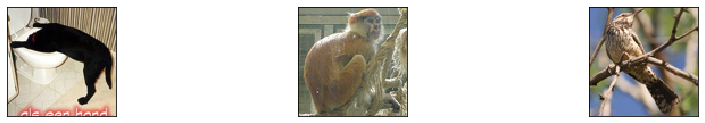

In [57]:
display_images(images,4)

In [0]:
#Noise Functions
def salt_and_pepper(image,factor):
    noise_factor = factor
    
    x_train_noisy = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    
    return x_train_noisy,x_test_noisy

def gaussian_noise(x_train,mean,sigma,proportion):    
    x_train_noisy = []
    for i in range(x_train.shape[0]):
        image = x_train[i]
        noise = proportion*np.random.normal(mean,sigma,x_train[0].shape)
        x_train_noisy.append(image + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=image.shape))
     
    x_train_noisy = np.clip(x_train_noisy, 0, 1)
    
    return x_train_noisy

In [0]:
#Adding noise to images
def add_noise(images):
    #x_train = np.reshape(x_train, (len(x_train), 64*64))  # adapt this if using `channels_first` image data format
    #x_test = np.reshape(x_test, (len(x_test), 64*64))  # adapt this if using `channels_first` image data format
    batch = int(images.shape[0]/2);
    noise1 = gaussian_noise(images[0:batch],0,1,0.1)
    noise2 = gaussian_noise(images[batch:],0,1,0.5)
    
    noisy_set = []
    for data in [noise1,noise2]:
        for image in data:
            noisy_set.append(image)
    
    return np.array(noisy_set)

In [0]:
shuffle(images)
#Getting the noisy image set
#noisy_set = add_noise(images)
#ground_truth,noisy_images = pair_shuffle(images,noisy_set)

#images = rgb2gray(images)
#noise_factor = 0.5
#noisy_set = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
#noisy_set = np.clip(noisy_set, 0., 1.)


#noise_factor = 0.5
#noisy_set = 1-images
#noisy_set = np.clip(noisy_set, 0., 1.)

In [0]:
#noise_factor = 0.5
#x_train_noisy = train_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_X.shape)
#x_valid_noisy = valid_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=valid_X.shape)
#x_test_noisy = test_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)
#x_train_noisy = np.clip(x_train_noisy, 0., 1.)
#x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)
#x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [0]:
#display_images(noisy_set,10)
#print (noisy_images.shape)





Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4000, 96, 96, 3)
(1000, 96, 96, 3)


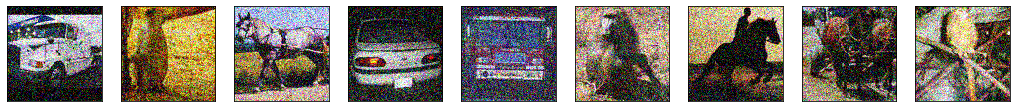

In [61]:
#ground_truth = ground_truth / np.max(ground_truth)
#noisy_images = noisy_images / np.max(noisy_images)

noise_factor = 0.2
#Split into training and cross validation
images = images / np.max(images)
train_size = int(images.shape[0]*0.8)
x_train = images[0:train_size]
#x_train_noisy = noisy_images[0:train_size]
x_train_noisy=x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test = images[train_size:]
#x_test_noisy = noisy_images[train_size:]
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
print (x_train_noisy.shape)
print (x_test_noisy.shape)
display_images(x_train_noisy,10)


In [0]:
from keras.layers import *
from keras.layers.core import Lambda
from keras.models import Model
from keras import regularizers
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.callbacks import History 
import keras
from matplotlib import pyplot as plt
import gzip
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.optimizers import RMSprop


In [0]:
def get_gated_connections(gatePercentageFactor,inputLayer):
    gateFactor = Input(tensor = K.variable([gatePercentageFactor]))
    fractionG = Lambda(lambda x: x[0]*x[1])([inputLayer,gateFactor])
    complement = Lambda(lambda x: x[0] - x[1])([inputLayer,fractionG])
    
    return gateFactor,fractionG,complement

#x is conv layer
#y is de-conv layer
#gf is gating factor
#fg is fractional input from gate
#c is complement ie remaining fraction from the gate
#jt joining tensor of convolution layer and previous de-conv layer 

input_img = Input(shape=(96,96,3))  # adapt this if using `channels_first` image data format

def autoencoder(input_img):
    #Encoder
    #input_img = Input(shape=(64,64,3))  # adapt this if using `channels_first` image data format
    '''x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    gf1,fg1,c1 = get_gated_connections(0.1,x1)
    
    x = MaxPooling2D((2, 2), padding='same')(fg1)
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x) 
    gf2,fg2,c2 = get_gated_connections(0.2,x2)

    x = MaxPooling2D((2, 2), padding='same')(fg2)
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same')(x) 
    gf3,fg3,c3 = get_gated_connections(0.3,x3)
    
    x = MaxPooling2D((2, 2), padding='same')(x3)
    x4 = Conv2D(256, (3, 3), activation='relu', padding='same')(x) 
    gf4,fg4,c4 = get_gated_connections(0.4,x4)
    
    x = MaxPooling2D((2, 2), padding='same')(x4)
    x5 = Conv2D(512, (3, 3), activation='relu', padding='same')(x) 
    #Decoder
    x = UpSampling2D((2, 2))(x5)
    y1 = Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(x) 
    jt4 = Add()([y1,c4])
    x = UpSampling2D((2, 2))(jt4)
    
    y2 = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x) 
    jt3 = Add()([y2,c3])
    x = UpSampling2D((2, 2))(jt3)
    
    y3 = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x) 
    jt2 = Add()([y3,c2])
    x = UpSampling2D((2, 2))(jt2)
    
    jt1 = Add()([x,c1])
    y4 = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(jt1)
    y5 = Conv2DTranspose(3, (3, 3), activation='relu', padding='same')(y4) 
    
    layers = y5
    
    #model = Model([input_img,gf1,gf2,gf3,gf4],layers)
    #model.compile(optimizer='sgd', loss = 'mean_squared_error', metrics = ['accuracy'])'''
    
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

In [0]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())
#model = get_cnn_architecture()

In [65]:
#Training
'''autoencoder_train = model.fit(np.array(x_train_noisy), np.array(x_train),
                epochs=50,
                batch_size=10,
                shuffle=True,
                validation_data=(np.array(x_test_noisy), np.array(x_test)),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder', histogram_freq=0, write_graph=True)])'''
autoencoder_train=autoencoder.fit(x_train_noisy, x_train, batch_size=8,epochs=32,verbose=1,validation_data=(x_test_noisy, x_test))
#Save the model
from keras.models import load_model
autoencoder.save('/content/drive/My Drive/Proyecto/data/4model.h5') 
#autoencoder.save('/content/drive/My Drive/Proyecto/data/2model.h5')  # 0.2 --8 epoch 8 batch
#autoencoder.save('/content/drive/My Drive/Proyecto/data/3model.h5')  # creates a HDF5 file 'my_model.h5'

Train on 4000 samples, validate on 1000 samples
Epoch 1/32
4000/4000 [==============================] - 7s 2ms/step - loss: 0.0170 - val_loss: 0.0108
Epoch 2/32
4000/4000 [==============================] - 6s 2ms/step - loss: 0.0086 - val_loss: 0.0102
Epoch 3/32
4000/4000 [==============================] - 6s 2ms/step - loss: 0.0071 - val_loss: 0.0060
Epoch 4/32
4000/4000 [==============================] - 6s 2ms/step - loss: 0.0064 - val_loss: 0.0056
Epoch 5/32
4000/4000 [==============================] - 6s 2ms/step - loss: 0.0059 - val_loss: 0.0068
Epoch 6/32
4000/4000 [==============================] - 6s 2ms/step - loss: 0.0056 - val_loss: 0.0059
Epoch 7/32
4000/4000 [==============================] - 6s 2ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 8/32
4000/4000 [==============================] - 6s 2ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 9/32
4000/4000 [==============================] - 6s 2ms/step - loss: 0.0050 - val_loss: 0.0044
Epoch 10/32
4000/4000 [===========

In [0]:
from keras.models import load_model      
autoencoder.save('/content/drive/My Drive/Proyecto/data/4model.h5')  # creates a HDF5 file 'my_model.h5'


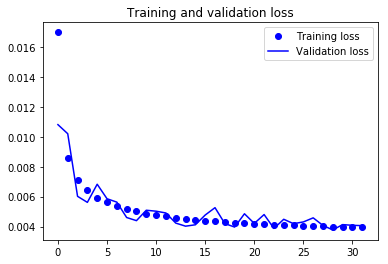

In [68]:
from keras.models import load_model
Modeltest = load_model('/content/drive/My Drive/Proyecto/data/4model.h5')

loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = 32
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
pred = autoencoder.predict(x_test_noisy)


Test Images


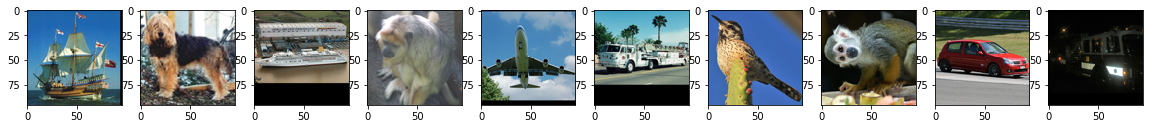

Test Images with Noise


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

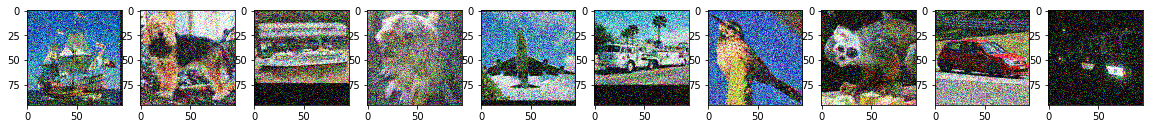

Reconstruction of Noisy Test Images


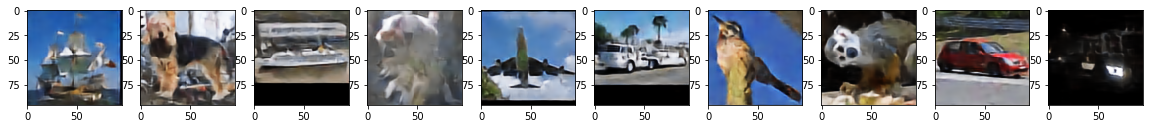

In [70]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test[i, ...])
plt.show()    
plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ...])
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ...])  
plt.show()